# This is a sample Jupyter Notebook

Below is an example of a code cell. 
Put your cursor into the cell and press Shift+Enter to execute it and select the next one, or click 'Run Cell' button.

Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/ipython-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).

In [28]:
import pandas as pd
from pathlib import Path

data_path = Path("data") / "train.xlsx"

price_list = pd.read_excel(
    data_path,
    header=0,
    parse_dates=[0],
)

# Set the first column (date) as index
price_list = (
    price_list
    .set_index(price_list.columns[0])
    .rename_axis("date")
)

# Standardize column names to HH:00 format
price_list.columns = [f"{hour:02d}:00" for hour in range(1, len(price_list.columns) + 1)]

# Create the flat array for the environment
training_prices = price_list.to_numpy().ravel()

price_list.head()

,01:00,02:00,03:00,04:00,05:00,06:00,07:00,08:00,09:00,10:00,...,15:00,16:00,17:00,18:00,19:00,20:00,21:00,22:00,23:00,24:00
date,,,,,,,,,,,,,,,,,,,,,
2007-01-01,24.31,24.31,21.71,8.42,0.01,0.01,0.02,0.01,0.01,6.31,...,15.00,10.00,8.17,27.77,37.99,33.11,37.99,33.00,36.48,30.65
2007-01-02,16.01,11.00,9.01,7.50,9.00,7.45,16.50,28.01,29.96,39.60,...,37.57,36.45,37.99,53.00,59.69,50.09,50.00,36.22,31.09,29.84
2007-01-03,28.00,24.50,24.15,18.99,15.50,23.11,29.01,39.73,43.81,49.09,...,43.21,43.99,48.00,57.00,60.99,55.51,51.77,34.51,39.31,38.05
2007-01-04,31.01,28.69,27.00,24.20,12.02,27.00,28.00,34.85,41.31,42.03,...,40.01,38.00,42.66,53.00,58.99,53.50,44.01,35.00,34.46,31.57
2007-01-05,22.00,19.50,17.55,15.91,11.40,22.65,27.30,34.00,40.01,45.00,...,40.06,38.00,38.61,49.84,53.00,45.91,36.74,29.61,30.61,27.51


In [29]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from dataclasses import dataclass
from typing import Optional, Dict, Any

@dataclass
class DamConfig:
    prices: np.ndarray
    Wmax: float = 100_000.0
    Vmax: float = 18_000.0
    W_init: float = 50_000.0
    g: float = 9.81
    rho: float = 1000.0
    h: float = 30.0
    eta_turbine: float = 0.9
    eta_pump: float = 0.8


class DamEnvGym(gym.Env):
    metadata = {"render_modes": []}

    def __init__(self, config: DamConfig):
        super().__init__()
        self.cfg = config

        # --- action & observation spaces ---
        self.action_space = spaces.Discrete(3)  # idle, sell, buy
        self.observation_space = spaces.Box(
            low=np.array([0.0, -np.inf], dtype=np.float32),
            high=np.array([1.0, np.inf], dtype=np.float32),
            dtype=np.float32,
        )

        self.reset()

    def _potential_energy_mwh(self, volume_m3: float) -> float:
        joules = self.cfg.rho * self.cfg.g * self.cfg.h * volume_m3
        return joules / 3.6e9

    def _observation(self):
        return np.array(
            [self.W_t / self.cfg.Wmax, self.cfg.prices[self.t]],
            dtype=np.float32
        )

    def reset(self, *, seed: Optional[int] = None, options: Optional[dict] = None):
        super().reset(seed=seed)
        self.t = 0
        self.W_t = self.cfg.W_init
        self.pnl = 0.0
        return self._observation(), {}

    def step(self, action: int):
        price = self.cfg.prices[self.t]

        if action == 1:      # sell
            V = min(self.cfg.Vmax, self.W_t)
        elif action == 2:    # buy
            V = min(self.cfg.Vmax, self.cfg.Wmax - self.W_t)
        else:                # idle
            V = 0.0

        E_pot = self._potential_energy_mwh(V)

        if action == 1 and V > 0:
            reward = price * (self.cfg.eta_turbine * E_pot)
            self.W_t -= V
        elif action == 2 and V > 0:
            reward = -price * (E_pot / self.cfg.eta_pump)
            self.W_t += V
        else:
            reward = 0.0

        self.pnl += reward
        self.t += 1

        terminated = self.t >= len(self.cfg.prices)
        truncated = False

        obs = self._observation() if not terminated else None
        info: Dict[str, Any] = {"pnl": self.pnl, "volume": V}

        return obs, reward, terminated, truncated, info

In [30]:
# Validation data loading
data_path = Path("data") / "validate.xlsx"

price_list_validate = pd.read_excel(
    data_path,
    header=0,
    parse_dates=[0],
)

# Use price_list_validate.columns[0] instead of price_list.columns[0]
price_list_validate = (
    price_list_validate
    .set_index(price_list_validate.columns[0])
    .rename_axis("date")
)

# Standardize column names exactly like the training set
price_list_validate.columns = [f"{hour:02d}:00" for hour in range(1, len(price_list_validate.columns) + 1)]

# Create the flat array for the environment
validation_prices = price_list_validate.to_numpy().ravel()

In [31]:
# bins
N_STORAGE = 6
N_PRICE = 6


storage_bins = np.linspace(0.0, 1.0, N_STORAGE + 1)
price_bins = np.quantile(training_prices, np.linspace(0, 1, N_PRICE + 1))

def discretize(obs):
    water_ratio, price = obs
    s_bin = np.digitize(water_ratio, storage_bins[1:-1])
    p_bin = np.digitize(price, price_bins[1:-1])
    return s_bin, p_bin


N_ACTIONS = 3
Q = np.zeros((N_STORAGE, N_PRICE, N_ACTIONS))

# visitation counters (state and state-action)
visit_counts_state = np.zeros((N_STORAGE, N_PRICE), dtype=np.int64)
visit_counts_sa = np.zeros((N_STORAGE, N_PRICE, N_ACTIONS), dtype=np.int64)

In [32]:
alpha = 0.1      # learning rate, maybe change
gamma = 0.9     # discount factor
epsilon = 0.05
eps_decay = 0.99
eps_min = 0.01
episodes = 200

for ep in range(episodes):
    env = DamEnvGym(DamConfig(prices=training_prices))
    obs, _ = env.reset()
    state = discretize(obs)

    done = False
    while not done:
        # epsilon-greedy action
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(Q[state])

        # track visitation for this state and (state, action)
        visit_counts_state[state] += 1
        visit_counts_sa[state + (int(action),)] += 1


        obs2, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        if not done:
            next_state = discretize(obs2)
            td_target = reward + gamma * np.max(Q[next_state])
        else:
            td_target = reward

        Q[state + (action,)] += alpha * (td_target - Q[state + (action,)])

        if not done:
            state = next_state

    epsilon = max(eps_min, epsilon * eps_decay)

In [33]:
env = DamEnvGym(DamConfig(prices=validation_prices))
obs, _ = env.reset()
state = discretize(obs)

done = False
total_reward = 0.0

while not done:
    action = np.argmax(Q[state])
    obs, reward, terminated, truncated, _ = env.step(action)
    total_reward += reward
    done = terminated or truncated
    if not done:
        state = discretize(obs)

print("Validation PnL (Q-learning):", total_reward)

Validation PnL (Q-learning): 85.41174600000001


visit_counts_state shape: (6, 6)
visit_counts_sa shape: (6, 6, 3)
Total state visits: 5260800
Total state-action visits: 5260800


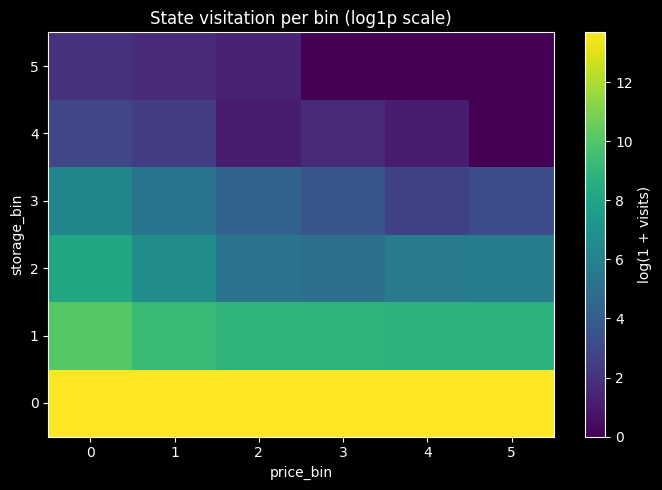

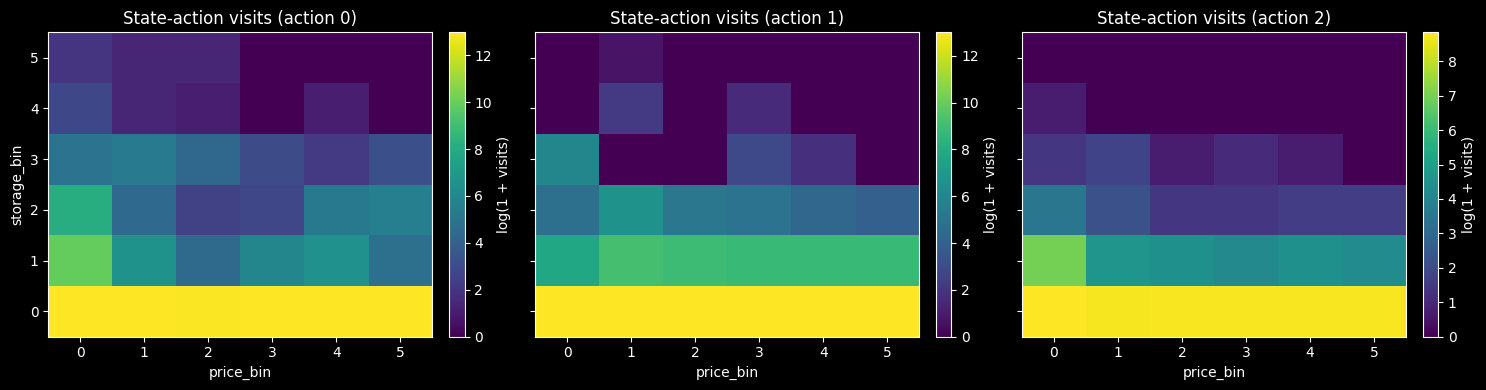

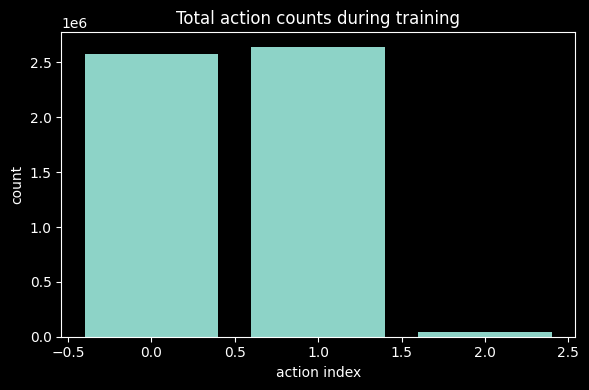

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# --- quick numeric checks ---
print("visit_counts_state shape:", visit_counts_state.shape)      # (N_STORAGE, N_PRICE)
print("visit_counts_sa shape:", visit_counts_sa.shape)            # (N_STORAGE, N_PRICE, N_ACTIONS)
print("Total state visits:", visit_counts_state.sum())
print("Total state-action visits:", visit_counts_sa.sum())

# --- (1) State visitation heatmap ---
plt.figure(figsize=(7, 5))
im = plt.imshow(np.log1p(visit_counts_state), origin="lower", aspect="auto")
plt.title("State visitation per bin (log1p scale)")
plt.xlabel("price_bin")
plt.ylabel("storage_bin")
plt.colorbar(im, label="log(1 + visits)")
plt.tight_layout()
plt.show()

# --- (2) State-action visitation heatmaps (one per action) ---
fig, axes = plt.subplots(1, N_ACTIONS, figsize=(5 * N_ACTIONS, 4), sharey=True)
for a in range(N_ACTIONS):
    ax = axes[a]
    im = ax.imshow(np.log1p(visit_counts_sa[:, :, a]), origin="lower", aspect="auto")
    ax.set_title(f"State-action visits (action {a})")
    ax.set_xlabel("price_bin")
    if a == 0:
        ax.set_ylabel("storage_bin")
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="log(1 + visits)")
plt.tight_layout()
plt.show()

# --- (3) Overall action usage during training ---
total_action_counts = visit_counts_sa.sum(axis=(0, 1))
plt.figure(figsize=(6, 4))
plt.bar(np.arange(N_ACTIONS), total_action_counts)
plt.title("Total action counts during training")
plt.xlabel("action index")
plt.ylabel("count")
plt.tight_layout()
plt.show()

In [35]:
K = 1000  # <- choose what "well visited" means (e.g., 10, 100, 1000)

total_bins = visit_counts_state.size  # should be N_STORAGE * N_PRICE (=100 here)

frac_visited = np.count_nonzero(visit_counts_state > 0) / total_bins
frac_well_visited = np.count_nonzero(visit_counts_state >= K) / total_bins

print(f"total_bins = {total_bins}")
print(f"frac_visited (count>0) = {frac_visited:.3f}")
print(f"frac_well_visited (count>={K}) = {frac_well_visited:.3f}")

# Optional: show distribution of visits to help pick K
flat = visit_counts_state.ravel()
print("visit count min/median/max:", int(flat.min()), int(np.median(flat)), int(flat.max()))
print("bins with 0 visits:", int(np.sum(flat == 0)))

total_bins = 36
frac_visited (count>0) = 0.889
frac_well_visited (count>=1000) = 0.361
visit count min/median/max: 0 194 881709
bins with 0 visits: 4


Q shape: (6, 6, 3)  expected: (6, 6, 3)


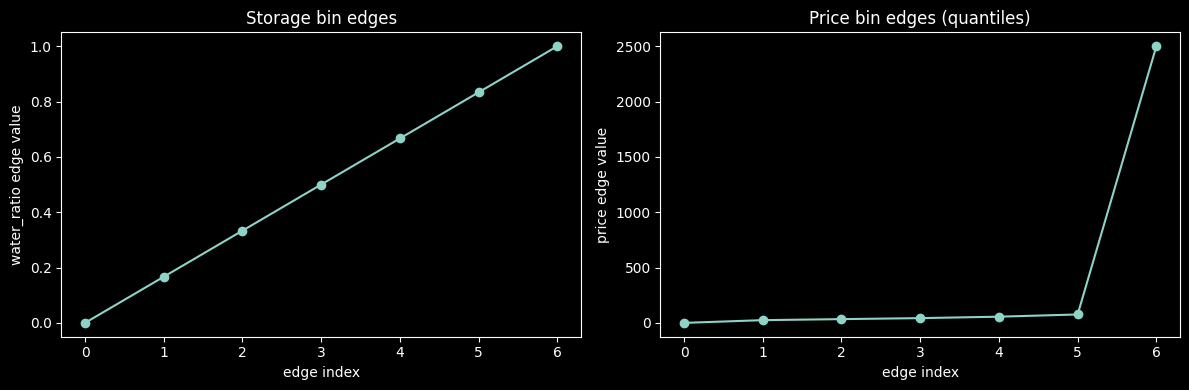

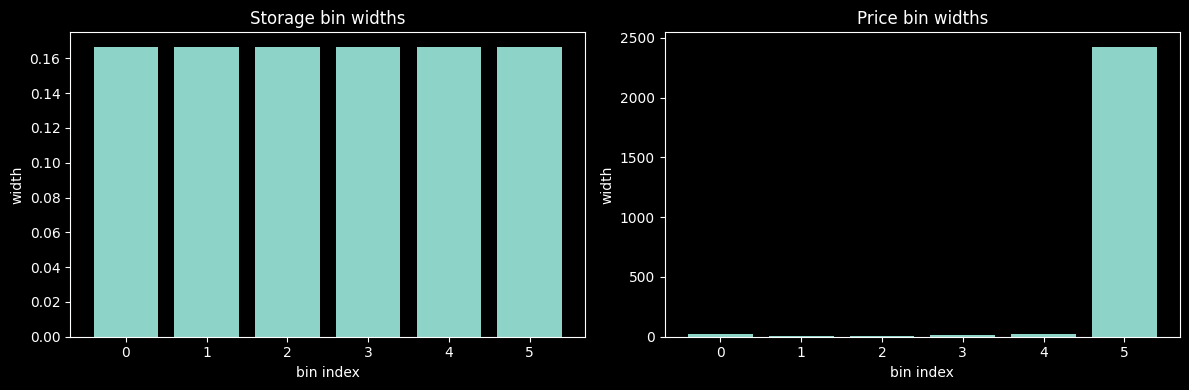

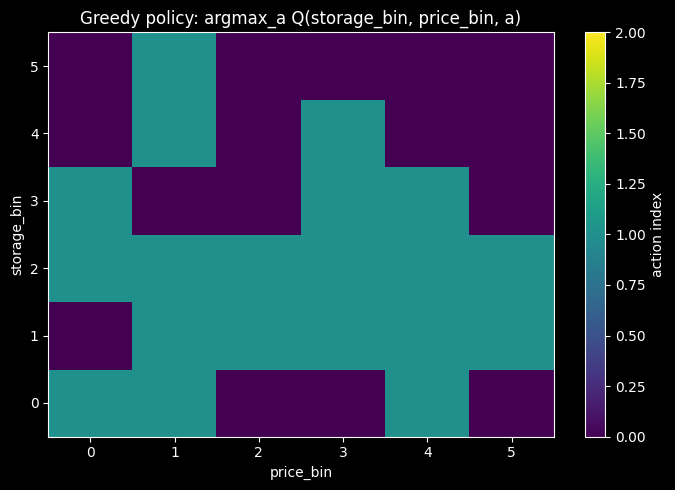

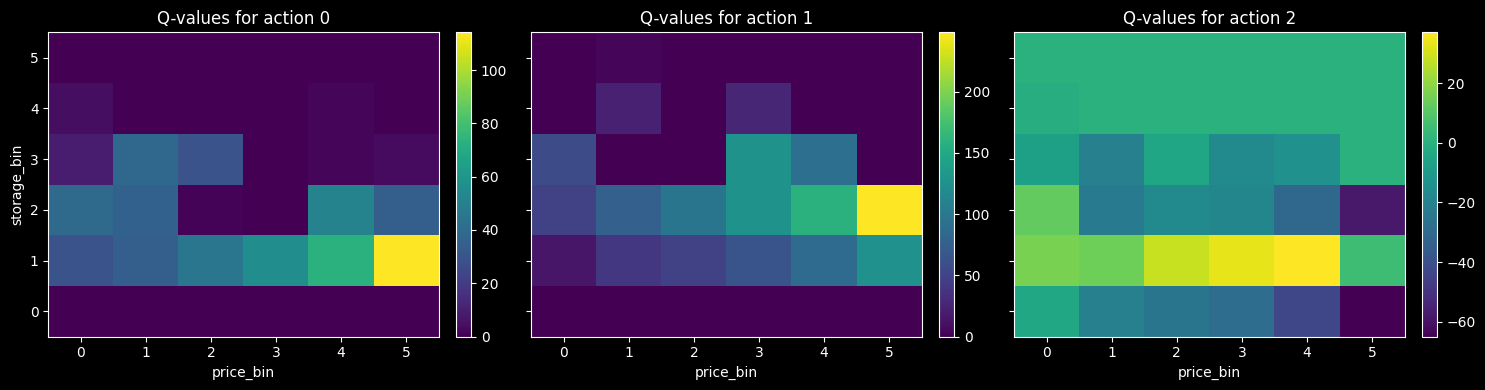

Greedy rollout action counts [0,1,2]: [13194 13110     0]  proportions: [0.50159672 0.49840328 0.        ]


In [36]:
# --- sanity checks ---
print("Q shape:", Q.shape, " expected:", (N_STORAGE, N_PRICE, N_ACTIONS))
assert Q.shape == (N_STORAGE, N_PRICE, N_ACTIONS)

# --- (1) Plot bin edges + widths (checks sizing) ---
storage_widths = np.diff(storage_bins)
price_widths = np.diff(price_bins)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(storage_bins, marker="o")
ax[0].set_title("Storage bin edges")
ax[0].set_xlabel("edge index")
ax[0].set_ylabel("water_ratio edge value")

ax[1].plot(price_bins, marker="o")
ax[1].set_title("Price bin edges (quantiles)")
ax[1].set_xlabel("edge index")
ax[1].set_ylabel("price edge value")

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].bar(np.arange(len(storage_widths)), storage_widths)
ax[0].set_title("Storage bin widths")
ax[0].set_xlabel("bin index")
ax[0].set_ylabel("width")

ax[1].bar(np.arange(len(price_widths)), price_widths)
ax[1].set_title("Price bin widths")
ax[1].set_xlabel("bin index")
ax[1].set_ylabel("width")
plt.tight_layout()
plt.show()

if np.any(price_widths <= 0):
    print("WARNING: Some price bins have zero/negative width (duplicate quantiles).")

# --- (2) Policy heatmap: which action is chosen in each (storage_bin, price_bin) ---
policy = np.argmax(Q, axis=2)  # shape (N_STORAGE, N_PRICE)

plt.figure(figsize=(7, 5))
im = plt.imshow(policy, origin="lower", aspect="auto", vmin=0, vmax=N_ACTIONS - 1)
plt.title("Greedy policy: argmax_a Q(storage_bin, price_bin, a)")
plt.xlabel("price_bin")
plt.ylabel("storage_bin")
cbar = plt.colorbar(im)
cbar.set_label("action index")
plt.tight_layout()
plt.show()

# --- (3) Q-value heatmaps per action (what the agent thinks each action is worth) ---
fig, axes = plt.subplots(1, N_ACTIONS, figsize=(5 * N_ACTIONS, 4), sharey=True)
for a in range(N_ACTIONS):
    ax = axes[a]
    im = ax.imshow(Q[:, :, a], origin="lower", aspect="auto")
    ax.set_title(f"Q-values for action {a}")
    ax.set_xlabel("price_bin")
    if a == 0:
        ax.set_ylabel("storage_bin")
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

# --- (4) Optional: action frequency in one greedy rollout (does it always idle/buy/sell?) ---
def greedy_action_hist(prices):
    env_tmp = DamEnvGym(DamConfig(prices=prices))
    obs, _ = env_tmp.reset()
    done = False
    counts = np.zeros(N_ACTIONS, dtype=int)

    while not done:
        s_bin, p_bin = discretize(obs)
        action = int(np.argmax(Q[s_bin, p_bin]))
        counts[action] += 1
        obs, _, terminated, truncated, _ = env_tmp.step(action)
        done = terminated or truncated

    return counts

counts = greedy_action_hist(training_prices)
print("Greedy rollout action counts [0,1,2]:", counts, " proportions:", counts / counts.sum())